Necessary imports

In [1]:
from fastMONAI.vision_all import *

from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split
import pandas as pd

C:\Users\Eirik\anaconda3\envs\raskmonai\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


Setting path and loading data

In [2]:
path = Path('..\data')
path.mkdir(exist_ok=True)

In [3]:
HeartSetTrain = DecathlonDataset(root_dir=path, task="Task02_Heart", section="training", download=False,
                                 cache_num=0, num_workers=3)

In [4]:
HippocampusSet = DecathlonDataset(root_dir=path, task="Task04_Hippocampus", section="training", download=False,
                                 cache_num=0, num_workers=3)

Importsing saved models. In this case, both models have been trained on their respective datasets, with 30 epochs and lr found through learner.lr_find()

In [25]:
HippocampusModel = load_learner('/Programmering/DAT255/SemesterProject/BaseLines/30_HippoCampus_model.pkl')

In [26]:
HeartModel = load_learner('/Programmering/DAT255/SemesterProject/BaseLines/30_Heart_model.pkl')

Same data prep and item_tfms as in baseline models.

In [5]:
df_heart_train = pd.DataFrame(HeartSetTrain.data)
med_dataset_heart_train = MedDataset(img_list=df_heart_train.label.tolist()[:20], dtype=MedMask, max_workers=12)
item_tfms = [ZNormalization(), PadOrCrop([160, 160, 128]), RandomAffine(scales=0, degrees=5, isotropic=True)]
resample, reorder = med_dataset_heart_train.suggestion()
resample, reorder

([1.25, 1.25, 1.37], False)

Creating medical datablock

In [6]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(seed=42),
                      get_x=ColReader('image'),
                      get_y=ColReader('label'),
                      item_tfms=item_tfms,
                      batch_tfms=None,
                      reorder=reorder,
                      resample=resample)

Batch size 2 is mostly good with 8GB of dedicated GPU-memory. Also creating the DL and showing a batch.

In [7]:
bs=2
dls_heart_train = dblock.dataloaders(df_heart_train, bs=bs)

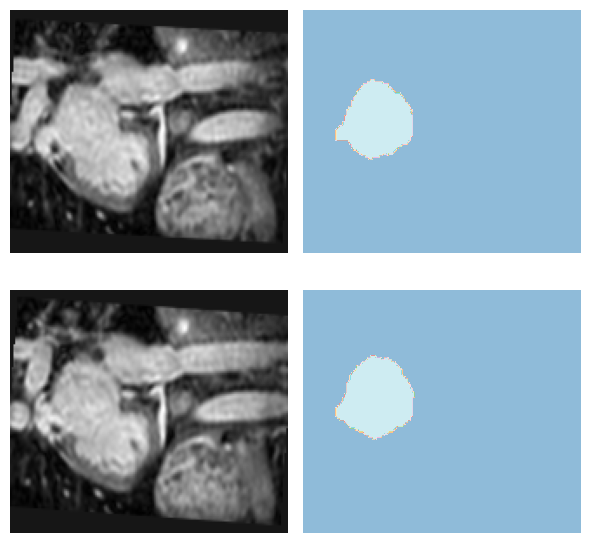

In [8]:
dls_heart_train.show_batch(anatomical_plane=0, unique=True)

Swapping the dataloader in HippocampusModel to the heart dataset.

In [11]:
HippocampusModel.dls = dls_heart_train

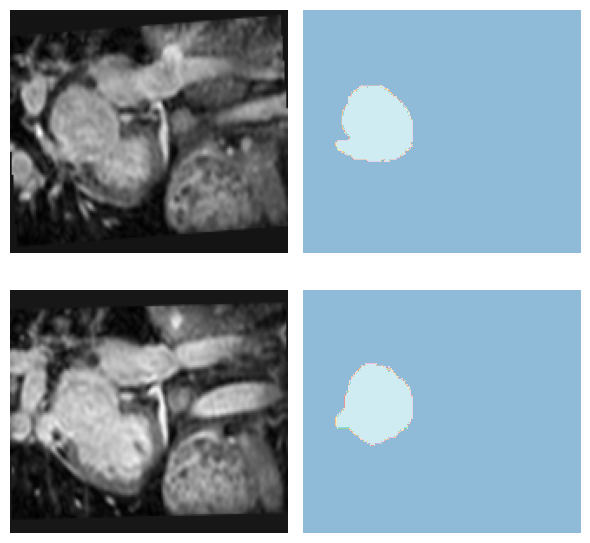

In [32]:
HippocampusModel.dls.show_batch(anatomical_plane=0, unique=True)

Finding learning rate for the first 30 epochs, as to keep it similar to how the heart model was trained at first.

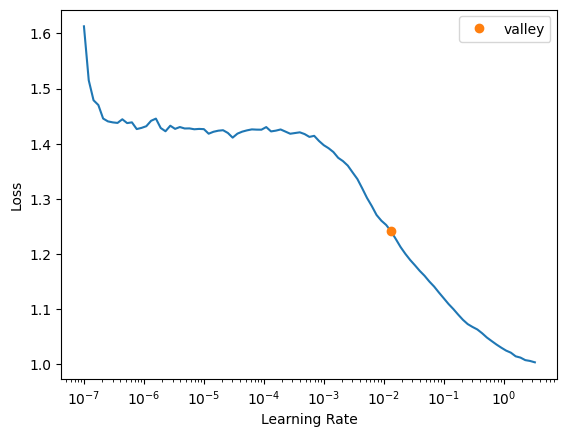

In [33]:
lr = HippocampusModel.lr_find()

Doing the same amount of epochs as the heart model.

In [34]:
epochs = 30
HippocampusModel.fit_flat_cos(epochs, lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,1.353456,1.227689,"tensor([0., nan])",00:07
1,1.156338,0.835529,"tensor([0., nan])",00:07
2,1.029744,0.684106,"tensor([0.1388, nan])",00:07
3,0.938877,0.696738,"tensor([0.0745, nan])",00:07
4,0.875710,0.672249,"tensor([0.1730, nan])",00:07
5,0.831983,0.667311,"tensor([0.1878, nan])",00:06
6,0.799601,0.661559,"tensor([0.1795, nan])",00:08
7,0.774518,0.656774,"tensor([0.1878, nan])",00:07
8,0.755206,0.652323,"tensor([0.2041, nan])",00:07
9,0.739259,0.648478,"tensor([0.2225, nan])",00:07


C:\Users\Eirik\anaconda3\envs\raskmonai\lib\site-packages\fastMONAI\vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work


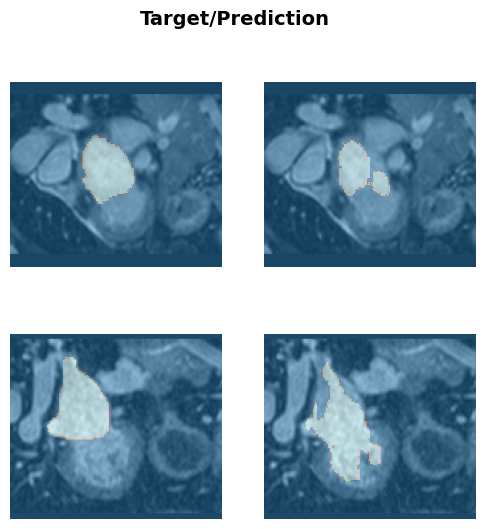

In [35]:
HippocampusModel.show_results(anatomical_plane=0, ds_idx=1)

In [36]:
test_dl = HippocampusModel.dls.test_dl(df_heart_train,with_labels=True)
pred_acts, labels = HippocampusModel.get_preds(dl=test_dl)
multi_dice_score(pred_acts, labels)

tensor([0.8024,    nan])

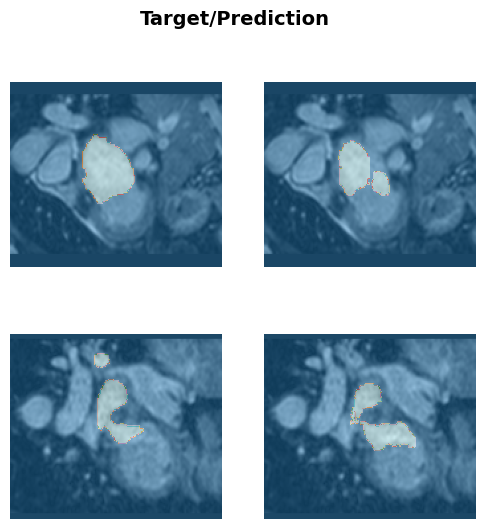

In [37]:
HippocampusModel.show_results(anatomical_plane=0, dl=test_dl)

Training for another 30 epochs with quite a low learning rate. This learning rate was found (through expiremantion) to work quite well.

In [38]:
HippocampusModel.fit_flat_cos(epochs, 5*10**-3)

epoch,train_loss,valid_loss,multi_dice_score,time
0,0.416641,0.459521,"tensor([0.7189, nan])",00:07
1,0.413631,0.447437,"tensor([0.7469, nan])",00:07
2,0.412253,0.434005,"tensor([0.7762, nan])",00:07
3,0.410680,0.429067,"tensor([0.7889, nan])",00:07
4,0.408224,0.429399,"tensor([0.7869, nan])",00:07
5,0.406160,0.420427,"tensor([0.8060, nan])",00:07
6,0.403764,0.417679,"tensor([0.8167, nan])",00:07
7,0.401982,0.419508,"tensor([0.8104, nan])",00:07
8,0.399829,0.421803,"tensor([0.8061, nan])",00:07
9,0.398227,0.419782,"tensor([0.8123, nan])",00:08


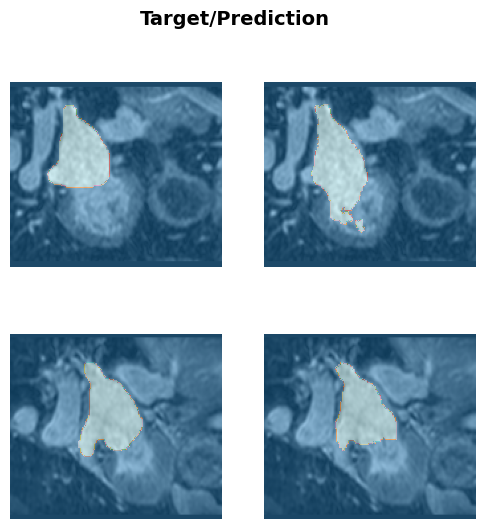

In [39]:
HippocampusModel.show_results(anatomical_plane=0, ds_idx=1)

Predicting on the unseen set put aside in the dataloader.

In [40]:
pred_acts, labels = HippocampusModel.get_preds(dl=test_dl)
multi_dice_score(pred_acts, labels)

tensor([0.9168,    nan])

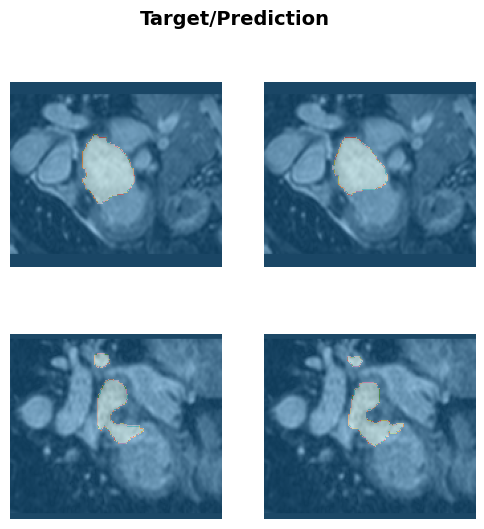

In [41]:
HippocampusModel.show_results(anatomical_plane=0, dl=test_dl)

Now lets train the HeartModel for 30 epochs. This results in both models having been trained with the same learning rates/way of finding learning rates and same amount of epochs.

In [42]:
HeartModel.dls = dls_heart_train
epochs = 30
HeartModel.fit_flat_cos(epochs, 5*10**-3)

epoch,train_loss,valid_loss,multi_dice_score,time
0,0.480261,0.507295,0.732233,00:07
1,0.480886,0.489228,0.758255,00:07
2,0.469494,0.470128,0.683988,00:07
3,0.457147,0.435595,0.760152,00:07
4,0.440550,0.403615,0.777846,00:07
5,0.421193,0.365684,0.784938,00:07
6,0.399197,0.330705,0.789109,00:07
7,0.377010,0.309463,0.743695,00:07
8,0.353841,0.264646,0.797796,00:07
9,0.329629,0.231626,0.817060,00:06


Getting predictions on the set put aside in the dataloader with the new model.

In [43]:
pred_acts, labels = HeartModel.get_preds(dl=test_dl)
multi_dice_score(pred_acts, labels)

tensor([0.9205])

It seems like the previous training actually had a negative effect on the final impact. Atleast in terms of Dice loss.

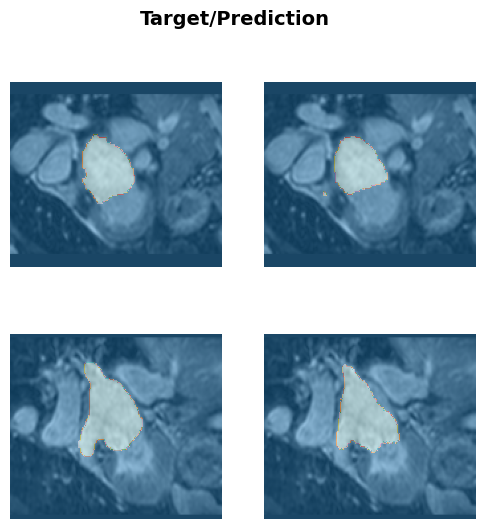

In [44]:
HeartModel.show_results(anatomical_plane=0, ds_idx=1)

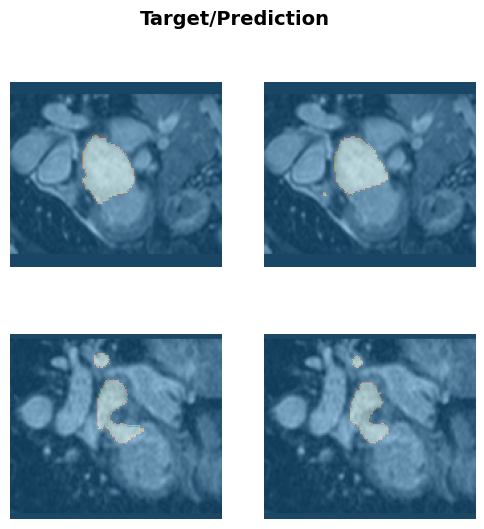

In [45]:
HeartModel.show_results(anatomical_plane=0, dl=test_dl)

The models seem to be quite similar from the batch examples aswell. Lets export these models and try one last thing. Since this dataset is quite small, running a lot of epochs is quite manageable. What if we decrease to the the amount of epochs to 5 for each model. The hippocampus model will then run 10 in total, 5 on the hippocampus set and 5 on the heart. The heart model will only run 5 on the heart set.

In [46]:
HippocampusModel.save('60hippocampus.heart-model')
HippocampusModel.export('60hippocampus2heart_model.pkl')

In [47]:
HeartModel.export('60_heart_model.pkl')

In [10]:
HippocampusModel = load_learner('/Programmering/DAT255/SemesterProject/BaseLines/30_HippoCampus_model.pkl')

In [12]:
HippocampusModel.dls = dls_heart_train

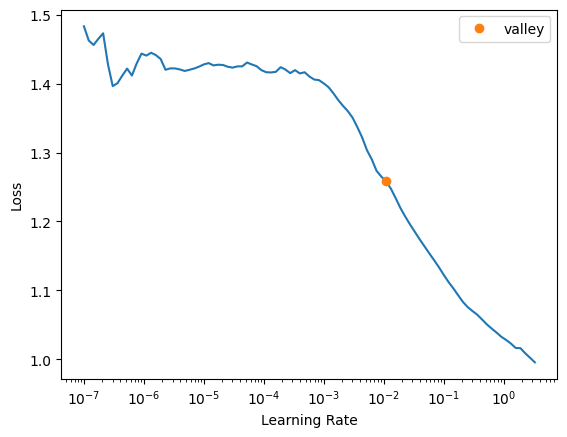

In [13]:
lr = HippocampusModel.lr_find()

In [14]:
HippocampusModel.fit_flat_cos(5, lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,1.355673,1.243543,"tensor([0., nan])",00:08
1,1.190402,0.886249,"tensor([0., nan])",00:07
2,1.062487,0.683665,"tensor([0.1481, nan])",00:08
3,0.953687,0.679755,"tensor([0.1392, nan])",00:07
4,0.884681,0.671771,"tensor([0.1739, nan])",00:07


C:\Users\Eirik\anaconda3\envs\raskmonai\lib\site-packages\fastMONAI\vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work


In [17]:
pred_acts, labels = HippocampusModel.get_preds(dl=test_dl)
multi_dice_score(pred_acts, labels)

tensor([0.1766,    nan])

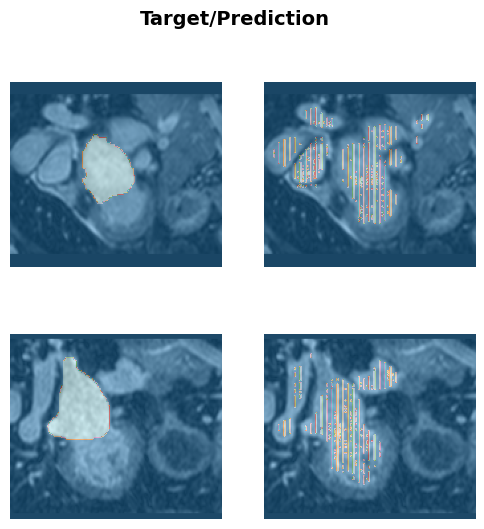

In [19]:
HippocampusModel.show_results(anatomical_plane=0, ds_idx=1)

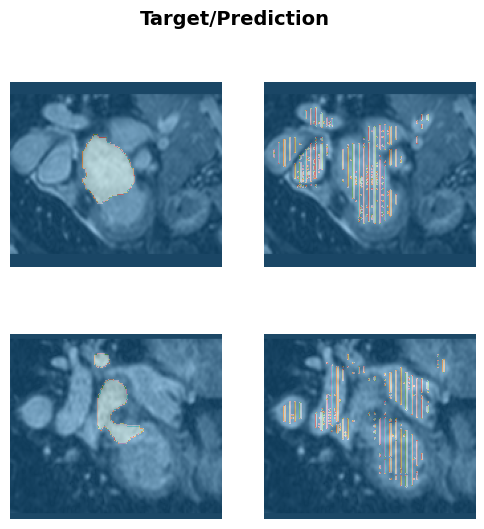

In [20]:
HippocampusModel.show_results(anatomical_plane=0, dl=test_dl)

As you one can see, the model performs quite poorly with only 5 epochs, but it is considerably better than the baseline heart model as seen in the picture below. Both visually and in loss function. Especially the amount of noise. It would be interesting to see a model where the pictures were squished instead of padded/cropped. Would it make a difference when the models run for more epochs?

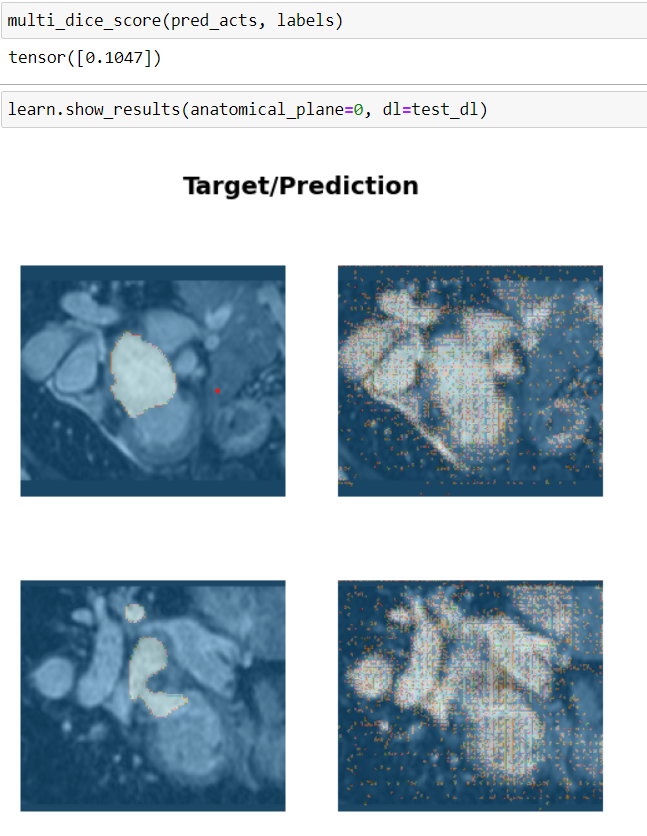